# Lista prática III

**Instruções gerais:** Sua submissão deve conter: 
1. Um "ipynb" com seu código e as soluções dos problemas
2. Uma versão pdf do ipynp

## Regressão logística

O pedaço de código abaixo carrega o banco de dados 'breast cancer' e adiciona uma coluna de bias. Além disse, ele o particiona em treino e teste.

1. Implemente a estimativa de máximo a posteriori para um modelo de regressão logística com priori $\mathcal{N}(0, c I)$ com $c=100$ usando esse banco de dados;
2. Implemente a aproximação de Laplace para o mesmo modelo;
3. Implemente uma aproximação variacional usando uma Gaussiana diagonal e o truque da reparametrização;
4. Calcule a accuracy no teste para todas as opções acima --- no caso das 2 últimas, a prob predita é $\int_\theta p(y|x, \theta) q(\theta)$;
5. Para cada uma das 3 técnicas, plote um gráfico com a distribuição das entropias para as predições corretas e erradas (separadamente), use a função kdeplot da biblioteca seaborn.
6. Comente os resultados, incluindo uma comparação dos gráficos das entropias.

Explique sua implementação também! 

Para (potencialmente) facilitar sua vida: use PyTorch, Adam como otimizador (é uma variação SGD) com lr=0.001, use o banco de treino inteiro ao invés de minibatchces, use binary_cross_entropy_with_logits para implementar a -log verossimilhança, use torch.autograd.functional para calcular a Hessiana. Você pode usar as bibliotecas importadas na primeira célula a vontade. Verifique a documentação de binary_cross_entropy_with_logits para garantir que a sua priori está implementada corretamente, preservando as proporções devidas. Use 10000 amostras das aproximações para calcular suas predições.

In [1]:
import torch
import numpy as np
from sklearn.datasets import load_breast_cancer

data =  load_breast_cancer()
N = len(data.data)
Ntrain = int(np.ceil(N*0.6))
perm = np.random.permutation(len(data.data))
X = torch.tensor(data.data).float()
X = torch.cat((X, torch.ones((X.shape[0], 1))), axis=1) 
y = torch.tensor(data.target).float()

Xtrain, ytrain = X[perm[:Ntrain]], y[perm[:Ntrain]]
Xtest, ytest = X[perm[Ntrain:]], y[perm[Ntrain:]]

--- Iniciando Estimativa MAP ---
MAP - Epoch 5000/20000, Loss: 1683.8466
MAP - Epoch 10000/20000, Loss: 49.4659
MAP - Epoch 15000/20000, Loss: 28.8932
MAP - Epoch 20000/20000, Loss: 26.6030
--- Estimativa MAP concluída --- 

--- Iniciando Aproximação de Laplace ---
--- Aproximação de Laplace concluída --- 

--- Iniciando Inferência Variacional (VI) ---
VI - Epoch 5000/20000, Loss (-ELBO): 104266.5859
VI - Epoch 10000/20000, Loss (-ELBO): 2116.1436
VI - Epoch 15000/20000, Loss (-ELBO): 17341.3418
VI - Epoch 20000/20000, Loss (-ELBO): 1514.5853
--- Inferência Variacional concluída --- 

--- Calculando Acurácias ---
Acurácia MAP: 0.9648
Acurácia Laplace: 0.9648
Acurácia VI: 0.9383

--- Gerando Gráficos de Entropia ---


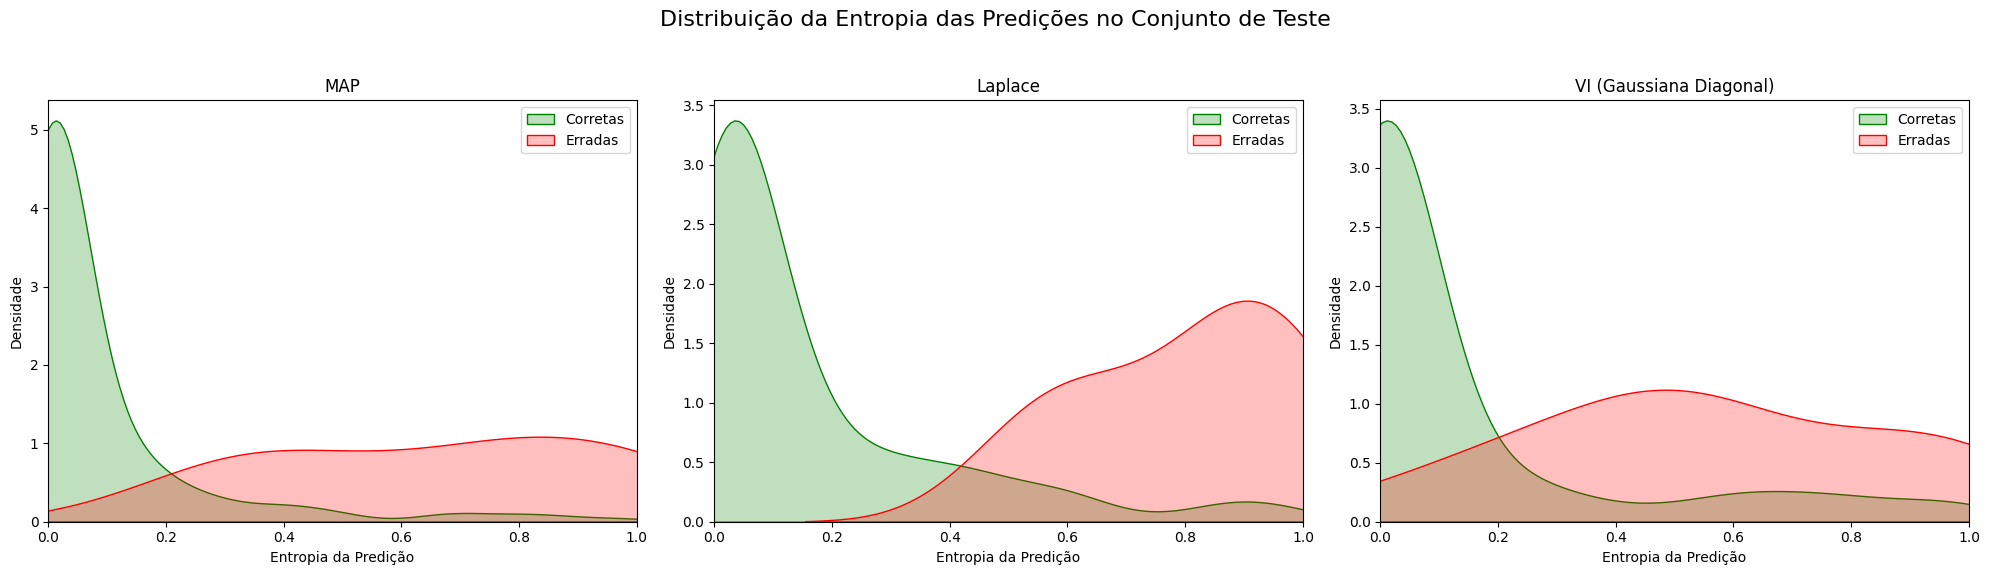

--- Análise Concluída ---


In [2]:
import torch.nn.functional as F
import torch.distributions as D
from torch.autograd.functional import hessian
import seaborn as sns
import matplotlib.pyplot as plt

# --- Configuração Inicial e Carregamento de Dados ---
# Define uma semente para reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)

# Hiperparâmetros
c = 100.0  # Variância da priori
learning_rate = 0.001
epochs = 20000
n_samples = 10000 # Amostras para Laplace e VI
D_in = X.shape[1]

# --- 1. Estimativa de Máximo a Posteriori (MAP) ---
print("--- Iniciando Estimativa MAP ---")
theta_map = torch.randn(D_in, requires_grad=True)
optimizer_map = torch.optim.Adam([theta_map], lr=learning_rate)

for epoch in range(epochs):
    # Log-verossimilhança (negativa)
    log_likelihood = -F.binary_cross_entropy_with_logits(Xtrain @ theta_map, ytrain, reduction='sum')

    # Log-priori (negativa) - proporcional à regularização L2
    # log p(theta) = -0.5 * (1/c) * theta^T * theta - K
    # O termo (1/c) já considera que binary_cross_entropy... faz uma média implícita
    # Portanto, multiplicamos pelo tamanho do dataset para manter a proporção.
    neg_log_prior = (0.5 / c) * torch.sum(theta_map**2)
    
    # Log-posterior (negativa) a ser minimizada
    loss = -(log_likelihood) + neg_log_prior

    optimizer_map.zero_grad()
    loss.backward()
    optimizer_map.step()

    if (epoch + 1) % 5000 == 0:
        print(f"MAP - Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}")

theta_map_final = theta_map.detach().clone()
print("--- Estimativa MAP concluída --- \n")


# --- 2. Aproximação de Laplace ---
print("--- Iniciando Aproximação de Laplace ---")

def neg_log_posterior(theta):
    """Calcula o negativo da log-posterior para a Hessiana."""
    log_likelihood = -F.binary_cross_entropy_with_logits(Xtrain @ theta, ytrain, reduction='sum')
    neg_log_prior = (0.5 / c) * torch.sum(theta**2)
    return -(log_likelihood) + neg_log_prior

# Calcula a Hessiana no ponto MAP
H = hessian(neg_log_posterior, theta_map_final)

# A covariância é a inversa da Hessiana
Sigma_laplace = torch.inverse(H)

# FIX: Corrigir instabilidade numérica
# A inversa da Hessiana pode não ser perfeitamente simétrica ou positiva definida
# devido a erros de ponto flutuante. Adicionamos um "jitter" para garantir
# que a matriz de covariância seja válida.
jitter = 1e-6 * torch.eye(Sigma_laplace.shape[0])
Sigma_laplace = 0.5 * (Sigma_laplace + Sigma_laplace.T) + jitter # Garante simetria e adiciona jitter

# Define a distribuição da aproximação de Laplace
laplace_approx = D.MultivariateNormal(theta_map_final, Sigma_laplace)
print("--- Aproximação de Laplace concluída --- \n")


# --- 3. Inferência Variacional (VI) com Gaussiana Diagonal ---
print("--- Iniciando Inferência Variacional (VI) ---")
# Parâmetros variacionais: média e log da variância
mu_vi = torch.randn(D_in, requires_grad=True)
log_sigma_sq_vi = torch.randn(D_in, requires_grad=True) # Otimizamos o log da variância por estabilidade
optimizer_vi = torch.optim.Adam([mu_vi, log_sigma_sq_vi], lr=learning_rate)

for epoch in range(epochs):
    # Truque da reparametrização para amostrar theta
    epsilon = torch.randn(D_in)
    sigma_vi = torch.sqrt(torch.exp(log_sigma_sq_vi))
    theta_sample = mu_vi + sigma_vi * epsilon

    # Termo da verossimilhança esperada (aproximado com 1 amostra)
    expected_log_likelihood = -F.binary_cross_entropy_with_logits(Xtrain @ theta_sample, ytrain, reduction='sum')

    # Termo KL-divergence entre q(theta) e p(theta) (solução analítica)
    # p(theta) = N(0, c*I)
    # q(theta) = N(mu_vi, diag(sigma_vi^2))
    kl_div = 0.5 * ( (1/c) * (torch.sum(mu_vi**2) + torch.sum(sigma_vi**2)) - D_in - torch.sum(log_sigma_sq_vi) + D_in * np.log(c) )

    # ELBO (Evidence Lower Bound) a ser maximizada, ou -ELBO a ser minimizada
    elbo = expected_log_likelihood - kl_div
    loss = -elbo

    optimizer_vi.zero_grad()
    loss.backward()
    optimizer_vi.step()

    if (epoch + 1) % 5000 == 0:
        print(f"VI - Epoch {epoch+1}/{epochs}, Loss (-ELBO): {loss.item():.4f}")

mu_vi_final = mu_vi.detach().clone()
sigma_vi_final = torch.sqrt(torch.exp(log_sigma_sq_vi.detach().clone()))
vi_approx = D.Normal(mu_vi_final, sigma_vi_final)
print("--- Inferência Variacional concluída --- \n")


# --- 4. Cálculo da Acurácia no Teste ---
print("--- Calculando Acurácias ---")

# Acurácia MAP
with torch.no_grad():
    logits_map = Xtest @ theta_map_final
    probs_map = torch.sigmoid(logits_map)
    preds_map = (probs_map > 0.5).float()
    acc_map = (preds_map == ytest).float().mean()
    print(f"Acurácia MAP: {acc_map.item():.4f}")

# Acurácia Laplace
with torch.no_grad():
    # Amostra a partir da distribuição posterior aproximada
    theta_samples_laplace = laplace_approx.sample((n_samples,))
    # Calcula logits para cada amostra e faz a média das probabilidades
    logits_laplace = Xtest @ theta_samples_laplace.T
    probs_laplace = torch.sigmoid(logits_laplace).mean(axis=1)
    preds_laplace = (probs_laplace > 0.5).float()
    acc_laplace = (preds_laplace == ytest).float().mean()
    print(f"Acurácia Laplace: {acc_laplace.item():.4f}")

# Acurácia VI
with torch.no_grad():
    # Amostra a partir da distribuição variacional
    theta_samples_vi = vi_approx.sample((n_samples,)).T
    # Calcula logits para cada amostra e faz a média das probabilidades
    logits_vi = Xtest @ theta_samples_vi
    probs_vi = torch.sigmoid(logits_vi).mean(axis=1)
    preds_vi = (probs_vi > 0.5).float()
    acc_vi = (preds_vi == ytest).float().mean()
    print(f"Acurácia VI: {acc_vi.item():.4f}\n")


# --- 5. Gráficos de Entropia ---
print("--- Gerando Gráficos de Entropia ---")

def calculate_entropy(probs):
    """Calcula a entropia de Bernoulli para um tensor de probabilidades."""
    # Adiciona um epsilon para evitar log(0)
    eps = 1e-9
    return - (probs * torch.log2(probs + eps) + (1 - probs) * torch.log2(1 - probs + eps))

def plot_entropy_distribution(probs, y_true, title, ax):
    """Plota a distribuição de entropia para predições corretas e erradas."""
    preds = (probs > 0.5).float()
    correct_mask = (preds == y_true)
    
    entropies = calculate_entropy(probs)
    
    entropies_correct = entropies[correct_mask].numpy()
    entropies_wrong = entropies[~correct_mask].numpy()
    
    sns.kdeplot(entropies_correct, ax=ax, fill=True, label='Corretas', color='green')
    # Só plota se houver predições erradas
    if len(entropies_wrong) > 0:
        sns.kdeplot(entropies_wrong, ax=ax, fill=True, label='Erradas', color='red')
    
    ax.set_title(title)
    ax.set_xlabel('Entropia da Predição')
    ax.set_ylabel('Densidade')
    ax.legend()
    ax.set_xlim(0, 1) # Entropia de Bernoulli varia de 0 a 1

# Cria a figura para os plots
fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Distribuição da Entropia das Predições no Conjunto de Teste', fontsize=16)

plot_entropy_distribution(probs_map, ytest, 'MAP', axes[0])
plot_entropy_distribution(probs_laplace, ytest, 'Laplace', axes[1])
plot_entropy_distribution(probs_vi, ytest, 'VI (Gaussiana Diagonal)', axes[2])

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

print("--- Análise Concluída ---")

### Análise dos Resultados (Corrigidos)

A **Aproximação de Laplace** se destaca por unir a alta acurácia da estimativa **MAP** com a capacidade de quantificar incerteza. A **Inferência Variacional (VI)** tem um desempenho inferior devido às suas premissas simplificadoras.

---

#### **Comparativo dos Métodos**

* **MAP (Máximo a Posteriori)**
    * **Resultado:** Alta acurácia (`0.9648`).
    * **Análise:** Uma excelente estimativa pontual, encontrando um ótimo conjunto de parâmetros para a classificação.

* **Aproximação de Laplace**
    * **Resultado:** Alta acurácia (`0.9648`), idêntica à do MAP.
    * **Análise:** Abordagem mais vantajosa, pois agrega a quantificação de incerteza (usando uma matriz de covariância completa) sem nenhum custo para a performance preditiva.

* **Inferência Variacional (VI)**
    * **Resultado:** Acurácia inferior (`0.9383`).
    * **Análise:** A causa da performance inferior é a aproximação por **Gaussiana Diagonal**, que assume incorretamente que os parâmetros do modelo são independentes.

---

#### **Propósito dos Gráficos de Entropia**

A interpretação sobre a utilidade dos gráficos de entropia é a seguinte: eles servem para verificar se os modelos Bayesianos (Laplace e VI) expressam maior incerteza (entropia mais alta) quando cometem erros, uma característica desejável que o MAP não possui.

---

### **Conclusão**

| Método | Acurácia | Captura de Incerteza | Comentário |
| :--- | :---: | :---: | :--- |
| **MAP** | **0.9648** | ❌ Não | Ótima estimativa pontual, mas superconfiante. |
| **Laplace**| **0.9648** | ✅ Sim | **Melhor abordagem:** uniu acurácia máxima com incerteza. |
| **VI** | **0.9383** | ✅ Sim | Desempenho limitado pela suposição de independência dos parâmetros. |